In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from keras import models, layers
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras_unet.models import satellite_unet as unetModel
from skimage.morphology import label
import gc 
import cv2
from keras_unet.utils import plot_segm_history

In [2]:
### path initialisation
trainImagesPath = os.path.join('../input', 'train_v2/')
testImagesPath = os.path.join('../input', 'test_v2/')

In [1]:
## run length encoding-decoding and mask image generation
def decodeRle(rleMask):
    rleMask = rleMask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (rleMask[0:][::2], rleMask[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(768*768, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(768,768).T


def generateMaskImage(masksList):
    maskImage = np.zeros(shape=(768,768))
    for mask in masksList:
        decodedMask = decodeRle(mask)
        maskImage+=decodedMask
    return maskImage

In [4]:
## training csv file read
masks = pd.read_csv(os.path.join('../input/',
                                 'train_ship_segmentations_v2.csv'))
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

231723 masks found
192556


ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

Total images having ships : 42556

Number of Images having different number of ships



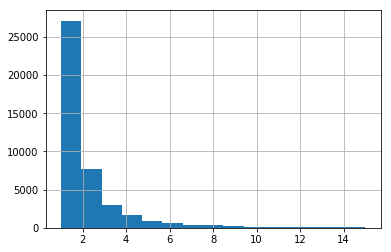

In [5]:
## distribution of ship images having different number of ships and data balancing
trainCsv = pd.read_csv("/kaggle/input/train_ship_segmentations_v2.csv")
shipsCsv = trainCsv
shipCsv = shipsCsv.dropna()
shipsCount = shipCsv.groupby(['ImageId'], sort=True).size().reset_index(name='Count')
print("Total images having ships :", len(shipsCount))
print("\nNumber of Images having different number of ships\n")
shipsCount["Count"].hist(bins=shipsCount['Count'].max())
shipsCount.sort_values("Count", axis = 0, ascending = False, inplace = True, na_position ='last') 



In [6]:
## dataset generation after balancing
def generateDataSet():
    trainImages = []
    testImages = []
    maxShipsCount = 15
    for i in range(1, maxShipsCount+1):
        n = shipsCount["Count"].loc[shipsCount["Count"]==i].count()
        print(i,n)
        trainCount = int(90*n/100)
        images = list(shipsCount["ImageId"].loc[shipsCount["Count"]==i])

        for imageName in images[:trainCount]:
            trainImages.append(imageName)
        for imageName in images[trainCount:]:
            testImages.append(imageName) 
            
    return trainImages, testImages

## adding images having no ships
def addNoShipImages(trainImages, testImages):
    noShipsCsv =trainCsv[trainCsv['EncodedPixels'].isnull()]
    noShipsImages = noShipsCsv.ImageId.tolist()
    trainImages = trainImages + noShipsImages[:2000]
    testImages = testImages + noShipsImages[2000:2200]
    return trainImages, testImages

In [7]:
trainImages, testImages = generateDataSet()
trainImages, testImages = addNoShipImages(trainImages, testImages)

1 27104
2 7674
3 2954
4 1622
5 925
6 657
7 406
8 318
9 243
10 168
11 144
12 124
13 75
14 76
15 66


In [8]:
print(len(trainImages), len(testImages))

40293 4463


aa
12


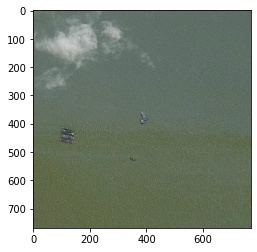

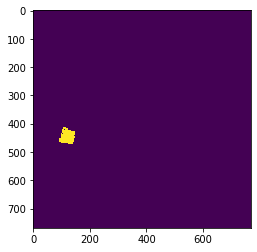

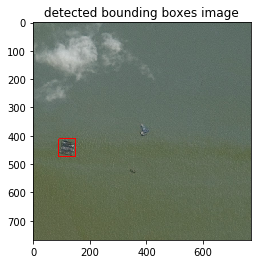

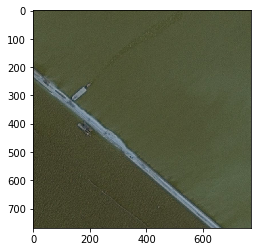

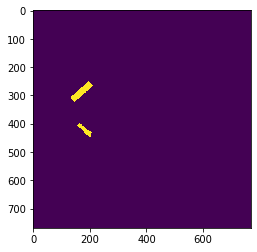

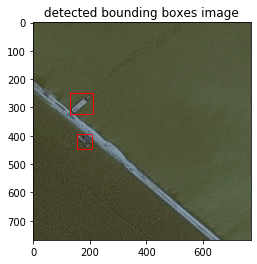

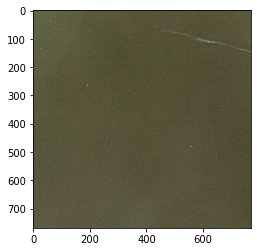

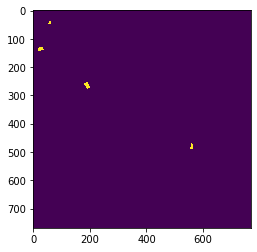

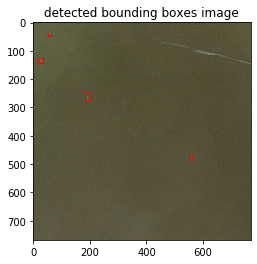

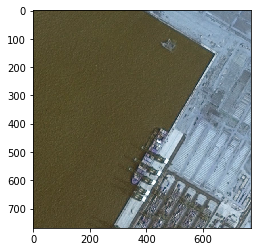

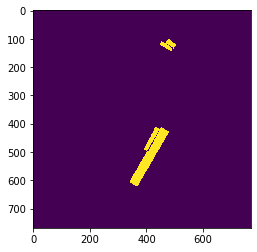

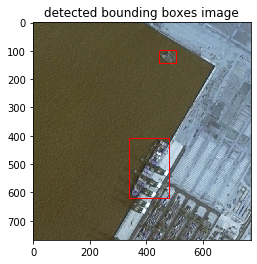

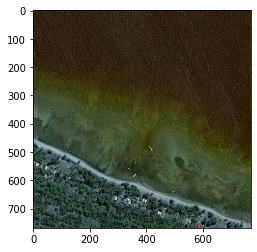

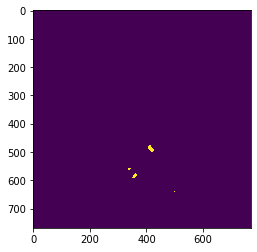

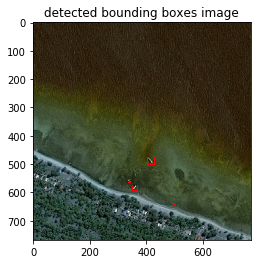

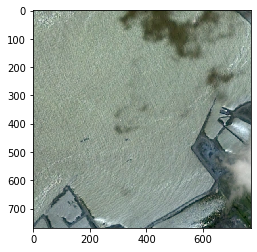

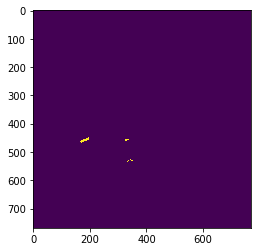

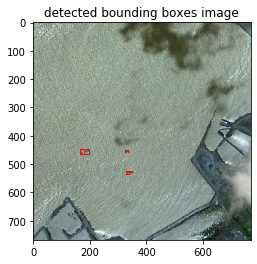

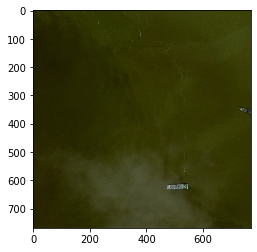

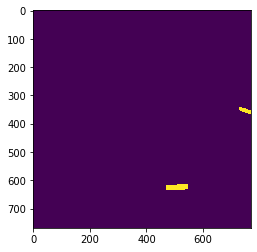

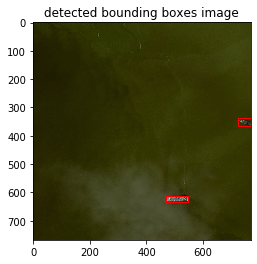

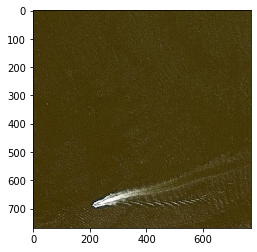

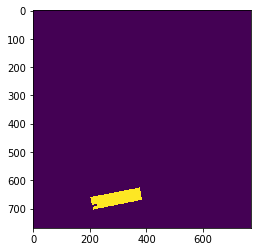

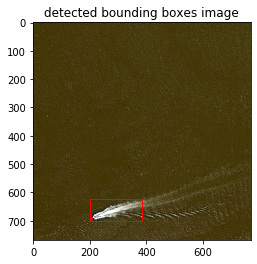

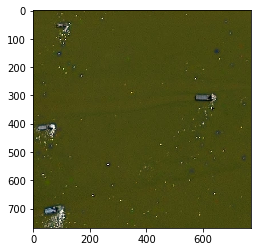

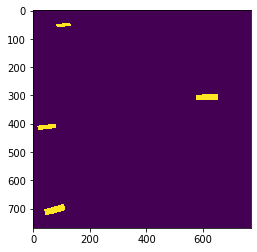

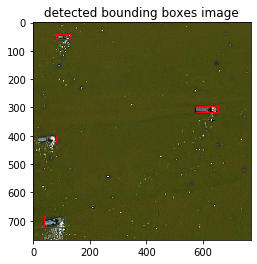

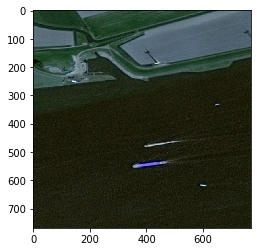

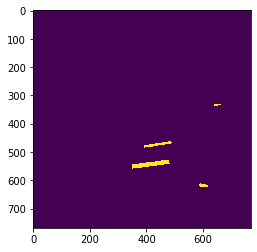

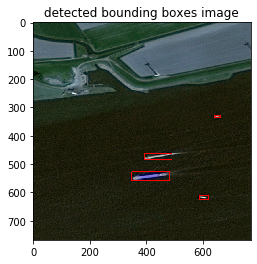

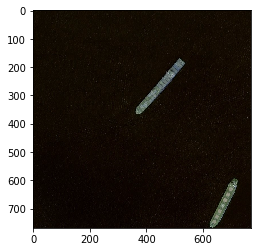

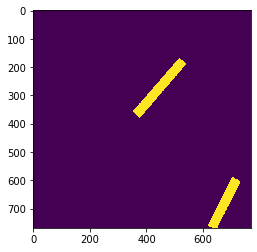

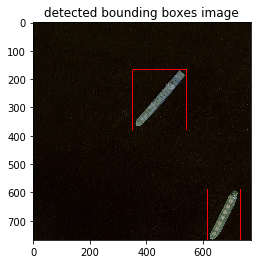

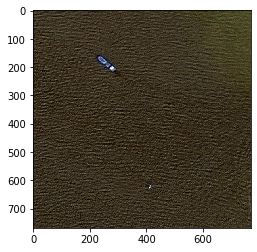

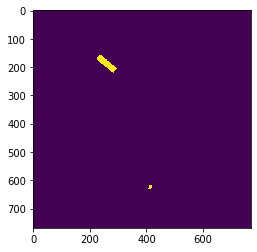

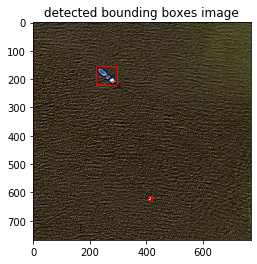

In [21]:
## sample training images, ground truth mask
import cv2, os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import label, regionprops
trainCsv = pd.read_csv("train_ship_segmentations_v2.csv")
print("aa")
for dr,_ , files in os.walk("images/"):
    print(len(files))
    for file in files:
        image = cv2.imread("images/"+file)
        plt.figure()
        plt.imshow(image)
        masksList = trainCsv.loc[trainCsv["ImageId"]==file]["EncodedPixels"]
        maskImage = generateMaskImage(masksList)
        plt.figure()
        plt.imshow(maskImage)
        coords = getBBoxFromMask(maskImage)
        image = cv2.imread("images/"+file)
        for coord in coords:
            cv2.rectangle(image, (coord.bbox[1], coord.bbox[0]), (coord.bbox[3], coord.bbox[2]), (255, 0, 0), 2)
        plt.figure()
        plt.title('detected bounding boxes image')
        plt.imshow(image)        
        

In [11]:
### image augmentation
sampleGenerator = ImageDataGenerator(rotation_range=20,
    zoom_range=0.25,
    shear_range=0.15,
    horizontal_flip=True,
    width_shift_range=0.3,
    height_shift_range=0.25)

maskGenerator = ImageDataGenerator(rotation_range=20,
    zoom_range=0.25,
    shear_range=0.15,
    horizontal_flip=True,
    width_shift_range=0.3,
    height_shift_range=0.25)
            
def augmentData(generator):
    for samples, masks in generator:
        augSamples = sampleGenerator.flow(255*samples, 
                             batch_size = samples.shape[0], 
                             seed = np.random.choice(range(10000)), 
                             shuffle=True)
        augMasks = maskGenerator.flow(masks, 
                             batch_size = samples.shape[0], 
                             seed = np.random.choice(range(10000)), 
                             shuffle=True)

        yield next(augSamples)/255.0, next(augMasks)

Using TensorFlow backend.


In [2]:
def getBBoxFromMask(maskImage):
    labels = label(maskImage) 
    coordinates = regionprops(labels)
    return coordinates

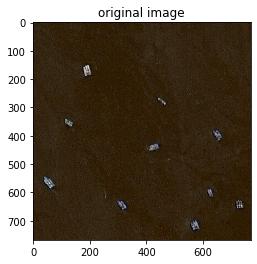

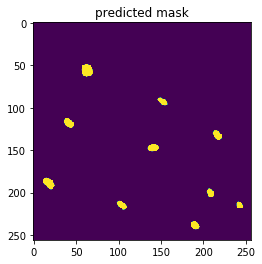

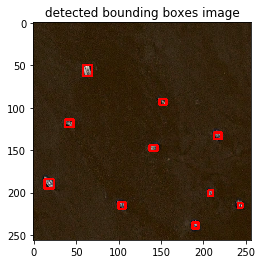

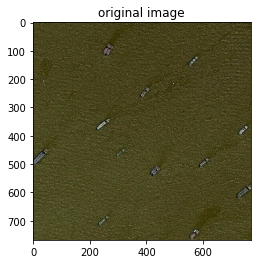

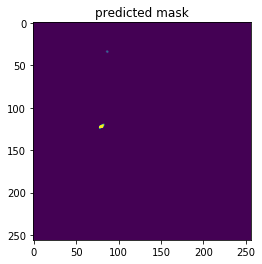

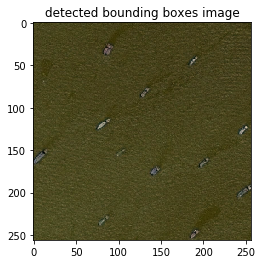

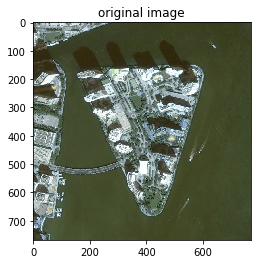

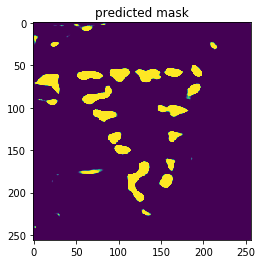

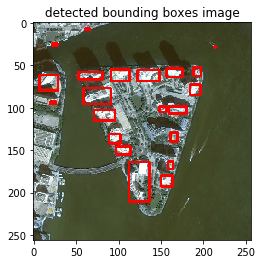

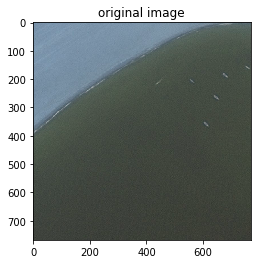

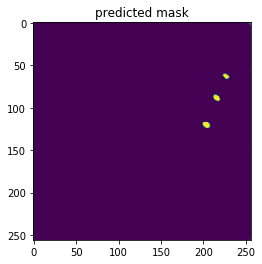

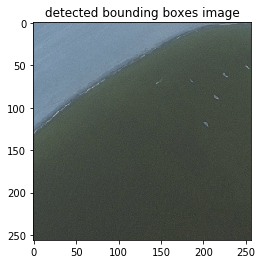

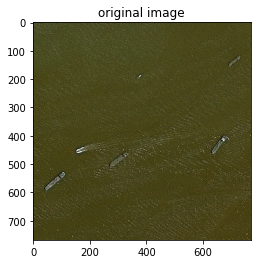

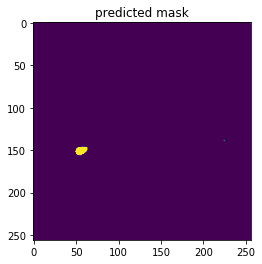

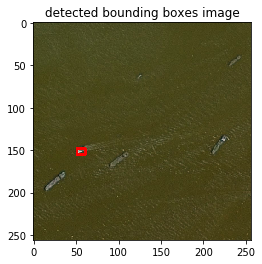

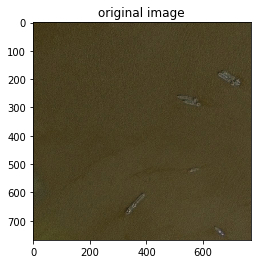

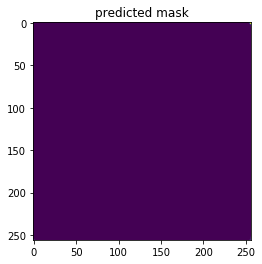

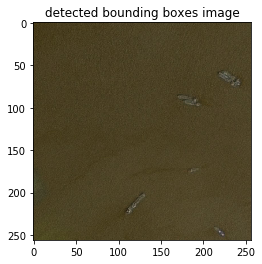

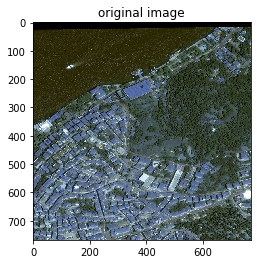

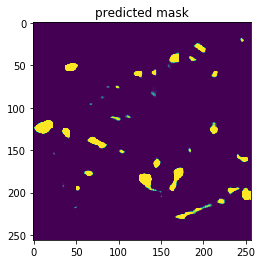

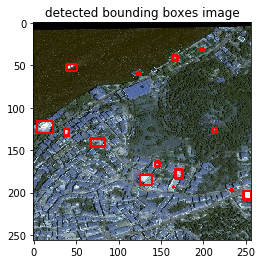

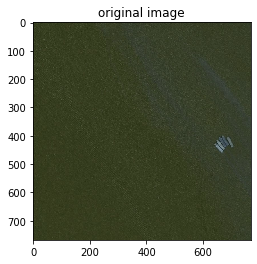

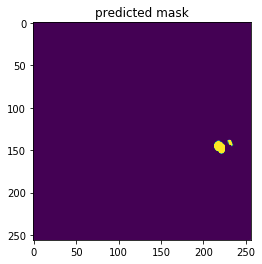

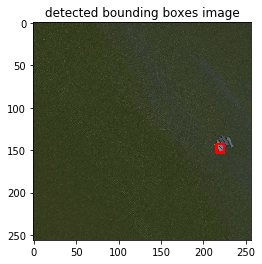

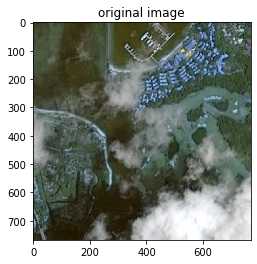

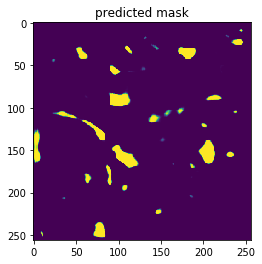

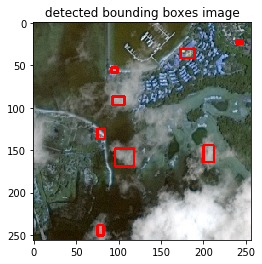

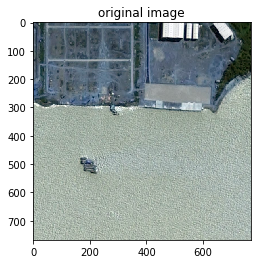

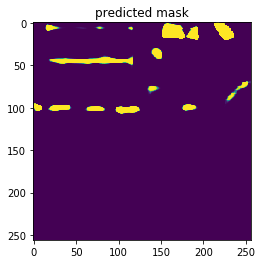

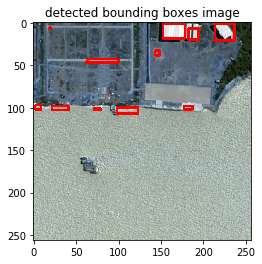

In [43]:
### bounding box generation
import os
import numpy as np
from skimage.measure import label, regionprops

count = 0
testImagesPath = "C:/Users\K\Desktop\ZAKI  FOLDER\mtech\sml\project\code\ships_small_dataset/test/"
for dir, _, files in os.walk(testImagesPath):
    for file in files[10:20]:
        path = os.path.join(testImagesPath, file)
        image = cv2.imread(path)
        plt.figure()
        plt.title('original image')
        plt.imshow(image)
        image = cv2.resize(image, (256, 256))
        image = np.expand_dims(image, 0)/255.0
        predictedMask = loaded_model.predict(image)
        plt.figure()
        plt.imshow(predictedMask[0,:,:, 0])
        plt.title('predicted mask')
        coords = getBBoxFromMask(predictedMask[0,:,:, 0])
        image = cv2.imread(path)
        image = cv2.resize(image, (256, 256))
        for coord in coords:
            cv2.rectangle(image, (coord.bbox[1], coord.bbox[0]), (coord.bbox[3], coord.bbox[2]), (255, 0, 0), 2)
        plt.figure()
        plt.title('detected bounding boxes image')
        plt.imshow(image)        


In [20]:
import warnings
warnings.filterwarnings('ignore')